In [61]:
from __future__ import print_function
import six

# import modules
import sys
import os
import time
import inspect
import getopt
import yaml
from pprint import pprint # for human readable file output
try:
    import cPickle as pickle
except:
    import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
import matplotlib.font_manager as font_manager
import scipy.stats as sps

#### Load cell file

In [62]:
## replace these with paths to your own files
cellfile_path = '/Volumes/JunLabSSD_03/growthlaw/20201008_sj1536/analysis/cell_data/otsu/complete_cells.pkl'
specfile_path = ''

with open(
    cellfile_path,
    'rb')as cell_file:
    Cells = pickle.load(cell_file, encoding='latin1')
    
# load specs file
with open(specfile_path, 'r') as specs_file:
    specs = yaml.safe_load(specs_file)

#### Make a dictionary of cell lineages with fov & peak # as keys

In [63]:
## get cells by peak
Cells_by_peak = mm3_plots.organize_cells_by_channel(Cells, specs)

##This gives the peak IDs for FOV 1
Cells_by_peak[1].keys()

dict_keys([68, 242, 286, 416, 460, 547, 677, 895])

#### Plot lineage trace for given FOV & peak ID

Text(0.5, 0, 'Time (minutes)')

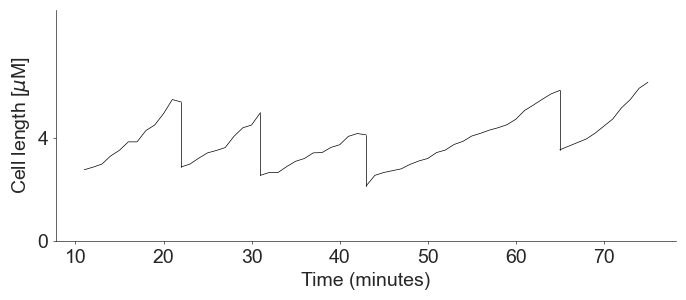

In [65]:
fov_id = 1
peak_id = 68

fig= plt.figure(figsize=(8,3))
ax=plt.axes()

for cell_id, cell in Cells_by_peak[fov_id][peak_id].items():
    if cell.birth_label==1:
        ax.plot(cell.times_w_div,np.array(cell.lengths_w_div),color='black',lw=.5)
        try:
            cell_m = Cells[cell.parent]
            ax.plot([cell_m.division_time,cell.birth_time],[cell_m.sd,cell.sb],ls='-',color='black')
        except:
            pass

ax.set_ylim(bottom=0,top=9)
ax.set_yticks([0,4])
sns.despine()

ax.set_ylabel('Cell length [$\mu$M]')
ax.set_xlabel('Time (minutes)')
# plt.tight_layout()

#### Make a dataframe

In [66]:
def cells2df(Cells):
    '''
    Take cell data (a dicionary of Cell objects) and return a dataframe.

    rescale : boolean
        If rescale is set to True, then the 6 major parameters are rescaled by their mean.
    '''
    # columns to include
    columns = ['fov', 'peak', 'birth_label',
               'birth_time', 'division_time',
               'sb', 'sd', 'width', 'delta', 'tau', 'elong_rate', 'septum_position']
    rescale_columns = ['sb', 'sd', 'width', 'delta', 'tau', 'elong_rate', 'septum_position']

    # Make dataframe for plotting variables
    Cells_dict = {cell_id : vars(cell) for cell_id, cell in Cells.items()}
    df = pd.DataFrame(Cells_dict).transpose() # must be transposed so data is in columns
    df = df.sort_values(by=['fov', 'peak', 'birth_time', 'birth_label'])
    df = df[columns].apply(pd.to_numeric)
    return df

#### Filter cell by stats

In [67]:
def filter_by_stat(Cells, center_stat='mean', std_distance=3):
    '''
    Filters a dictionary of Cells by ensuring all of the 6 major parameters are
    within some number of standard deviations away from either the mean or median
    '''

    # Calculate stats.
    Cells_df = cells2df(Cells)
    stats_columns = ['sb', 'sd', 'delta', 'elong_rate', 'tau', 'septum_position']
    cell_stats = Cells_df[stats_columns].describe()

    # set low and high bounds for each stat attribute
    bounds = {}
    for label in stats_columns:
        low_bound = cell_stats[label][center_stat] - std_distance*cell_stats[label]['std']
        high_bound = cell_stats[label][center_stat] + std_distance*cell_stats[label]['std']
        bounds[label] = {'low' : low_bound,
                         'high' : high_bound}

    # add filtered cells to dict
    fCells = {} # dict to hold filtered cells

    for cell_id, Cell in six.iteritems(Cells):
        benchmark = 0 # this needs to equal 6, so it passes all tests

        for label in stats_columns:
            attribute = getattr(Cell, label) # current value of this attribute for cell
            if attribute > bounds[label]['low'] and attribute < bounds[label]['high']:
                benchmark += 1

        if benchmark == 6:
            fCells[cell_id] = Cells[cell_id]

    return fCells

#### Other filtering functions

In [68]:
### Filtering functions ############################################################################
def find_cells_of_birth_label(Cells, label_num=1):
    '''Return only cells whose starting region label is given.
    If no birth_label is given, returns the mother cells.
    label_num can also be a list to include cells of many birth labels
    '''

    fCells = {} # f is for filtered

    if type(label_num) is int:
        label_num = [label_num]

    for cell_id in Cells:
        if Cells[cell_id].birth_label in label_num:
            fCells[cell_id] = Cells[cell_id]

    return fCells

def find_cells_of_fov(Cells, FOVs=[]):
    '''Return only cells from certain FOVs.

    Parameters
    ----------
    FOVs : int or list of ints
    '''

    fCells = {} # f is for filtered

    if type(FOVs) is int:
        FOVs = [FOVs]

    fCells = {cell_id : cell_tmp for cell_id, cell_tmp in six.iteritems(Cells) if cell_tmp.fov in FOVs}

    return fCells

def find_cells_of_fov_and_peak(Cells, fov_id, peak_id):
    '''Return only cells from a specific fov/peak
    Parameters
    ----------
    fov_id : int corresponding to FOV
    peak_id : int correstonging to peak
    '''

    fCells = {} # f is for filtered

    for cell_id in Cells:
        if Cells[cell_id].fov == fov_id and Cells[cell_id].peak == peak_id:
            fCells[cell_id] = Cells[cell_id]

    return fCells

def find_cells_born_before(Cells, born_before=None):
    '''
    Returns Cells dictionary of cells with a birth_time before the value specified
    '''

    if born_before == None:
        return Cells

    fCells = {cell_id : Cell for cell_id, Cell in six.iteritems(Cells) if Cell.birth_time <= born_before}

    return fCells

def find_cells_born_after(Cells, born_after=None):
    '''
    Returns Cells dictionary of cells with a birth_time after the value specified
    '''

    if born_after == None:
        return Cells

    fCells = {cell_id : Cell for cell_id, Cell in six.iteritems(Cells) if Cell.birth_time >= born_after}

    return fCells

def filter_by_stat(Cells, center_stat='mean', std_distance=3):
    '''
    Filters a dictionary of Cells by ensuring all of the 6 major parameters are
    within some number of standard deviations away from either the mean or median
    '''

    # Calculate stats.
    Cells_df = cells2df(Cells)
    stats_columns = ['sb', 'sd', 'delta', 'elong_rate', 'tau', 'septum_position']
    cell_stats = Cells_df[stats_columns].describe()

    # set low and high bounds for each stat attribute
    bounds = {}
    for label in stats_columns:
        low_bound = cell_stats[label][center_stat] - std_distance*cell_stats[label]['std']
        high_bound = cell_stats[label][center_stat] + std_distance*cell_stats[label]['std']
        bounds[label] = {'low' : low_bound,
                         'high' : high_bound}

    # add filtered cells to dict
    fCells = {} # dict to hold filtered cells

    for cell_id, Cell in six.iteritems(Cells):
        benchmark = 0 # this needs to equal 6, so it passes all tests

        for label in stats_columns:
            attribute = getattr(Cell, label) # current value of this attribute for cell
            if attribute > bounds[label]['low'] and attribute < bounds[label]['high']:
                benchmark += 1

        if benchmark == 6:
            fCells[cell_id] = Cells[cell_id]

    return fCells

def find_last_daughter(cell, Cells):
    '''Finds the last daughter in a lineage starting with a earlier cell.
    Helper function for find_continuous_lineages'''

    # go into the daugther cell if the daughter exists
    if cell.daughters[0] in Cells:
        cell = Cells[cell.daughters[0]]
        cell = find_last_daughter(cell, Cells)
    else:
        # otherwise just give back this cell
        return cell

    # finally, return the deepest cell
    return cell

def find_continuous_lineages(Cells, specs, t1=0, t2=1000):
    '''
    Uses a recursive function to only return cells that have continuous
    lineages between two time points. Takes a "lineage" form of Cells and
    returns a dictionary of the same format. Good for plotting
    with saw_tooth_plot()

    t1 : int
        First cell in lineage must be born before this time point
    t2 : int
        Last cell in lineage must be born after this time point
    '''

    Lineages = organize_cells_by_channel(Cells, specs)

    # This is a mirror of the lineages dictionary, just for the continuous cells
    Continuous_Lineages = {}

    for fov, peaks in six.iteritems(Lineages):
       # print("fov = {:d}".format(fov))
        # Create a dictionary to hold this FOV
        Continuous_Lineages[fov] = {}

        for peak, Cells in six.iteritems(peaks):
           # print("{:<4s}peak = {:d}".format("",peak))
            # sort the cells by time in a list for this peak
            cells_sorted = [(cell_id, cell) for cell_id, cell in six.iteritems(Cells)]
            cells_sorted = sorted(cells_sorted, key=lambda x: x[1].birth_time)

            # Sometimes there are not any cells for the channel even if it was to be analyzed
            if not cells_sorted:
                continue

            # look through list to find the cell born immediately before t1
            # and divides after t1, but not after t2
            for i, cell_data in enumerate(cells_sorted):
                cell_id, cell = cell_data
                if cell.birth_time < t1 and t1 <= cell.division_time < t2:
                    first_cell_index = i
                    break

            # filter cell_sorted or skip if you got to the end of the list
            if i == len(cells_sorted) - 1:
                continue
            else:
                cells_sorted = cells_sorted[i:]

            # get the first cell and its last contiguous daughter
            first_cell = cells_sorted[0][1]
            last_daughter = find_last_daughter(first_cell, Cells)

            # check to the daughter makes the second cut off
            if last_daughter.birth_time > t2:
                # print(fov, peak, 'Made it')

                # now retrieve only those cells within the two times
                # use the function to easily return in dictionary format
                Cells_cont = find_cells_born_after(Cells, born_after=t1)
                # Cells_cont = find_cells_born_before(Cells_cont, born_before=t2)

                # append the first cell which was filtered out in the above step
                Cells_cont[first_cell.id] = first_cell

                # and add it to the big dictionary
                Continuous_Lineages[fov][peak] = Cells_cont

        # remove keys that do not have any lineages
        if not Continuous_Lineages[fov]:
            Continuous_Lineages.pop(fov)

    Cells = lineages_to_dict(Continuous_Lineages) # revert back to return

    return Cells

#### Plot correlations and distributions

In [69]:
fCells = filter_by_stat(Cells)
fCells_df = cells2df(fCells)

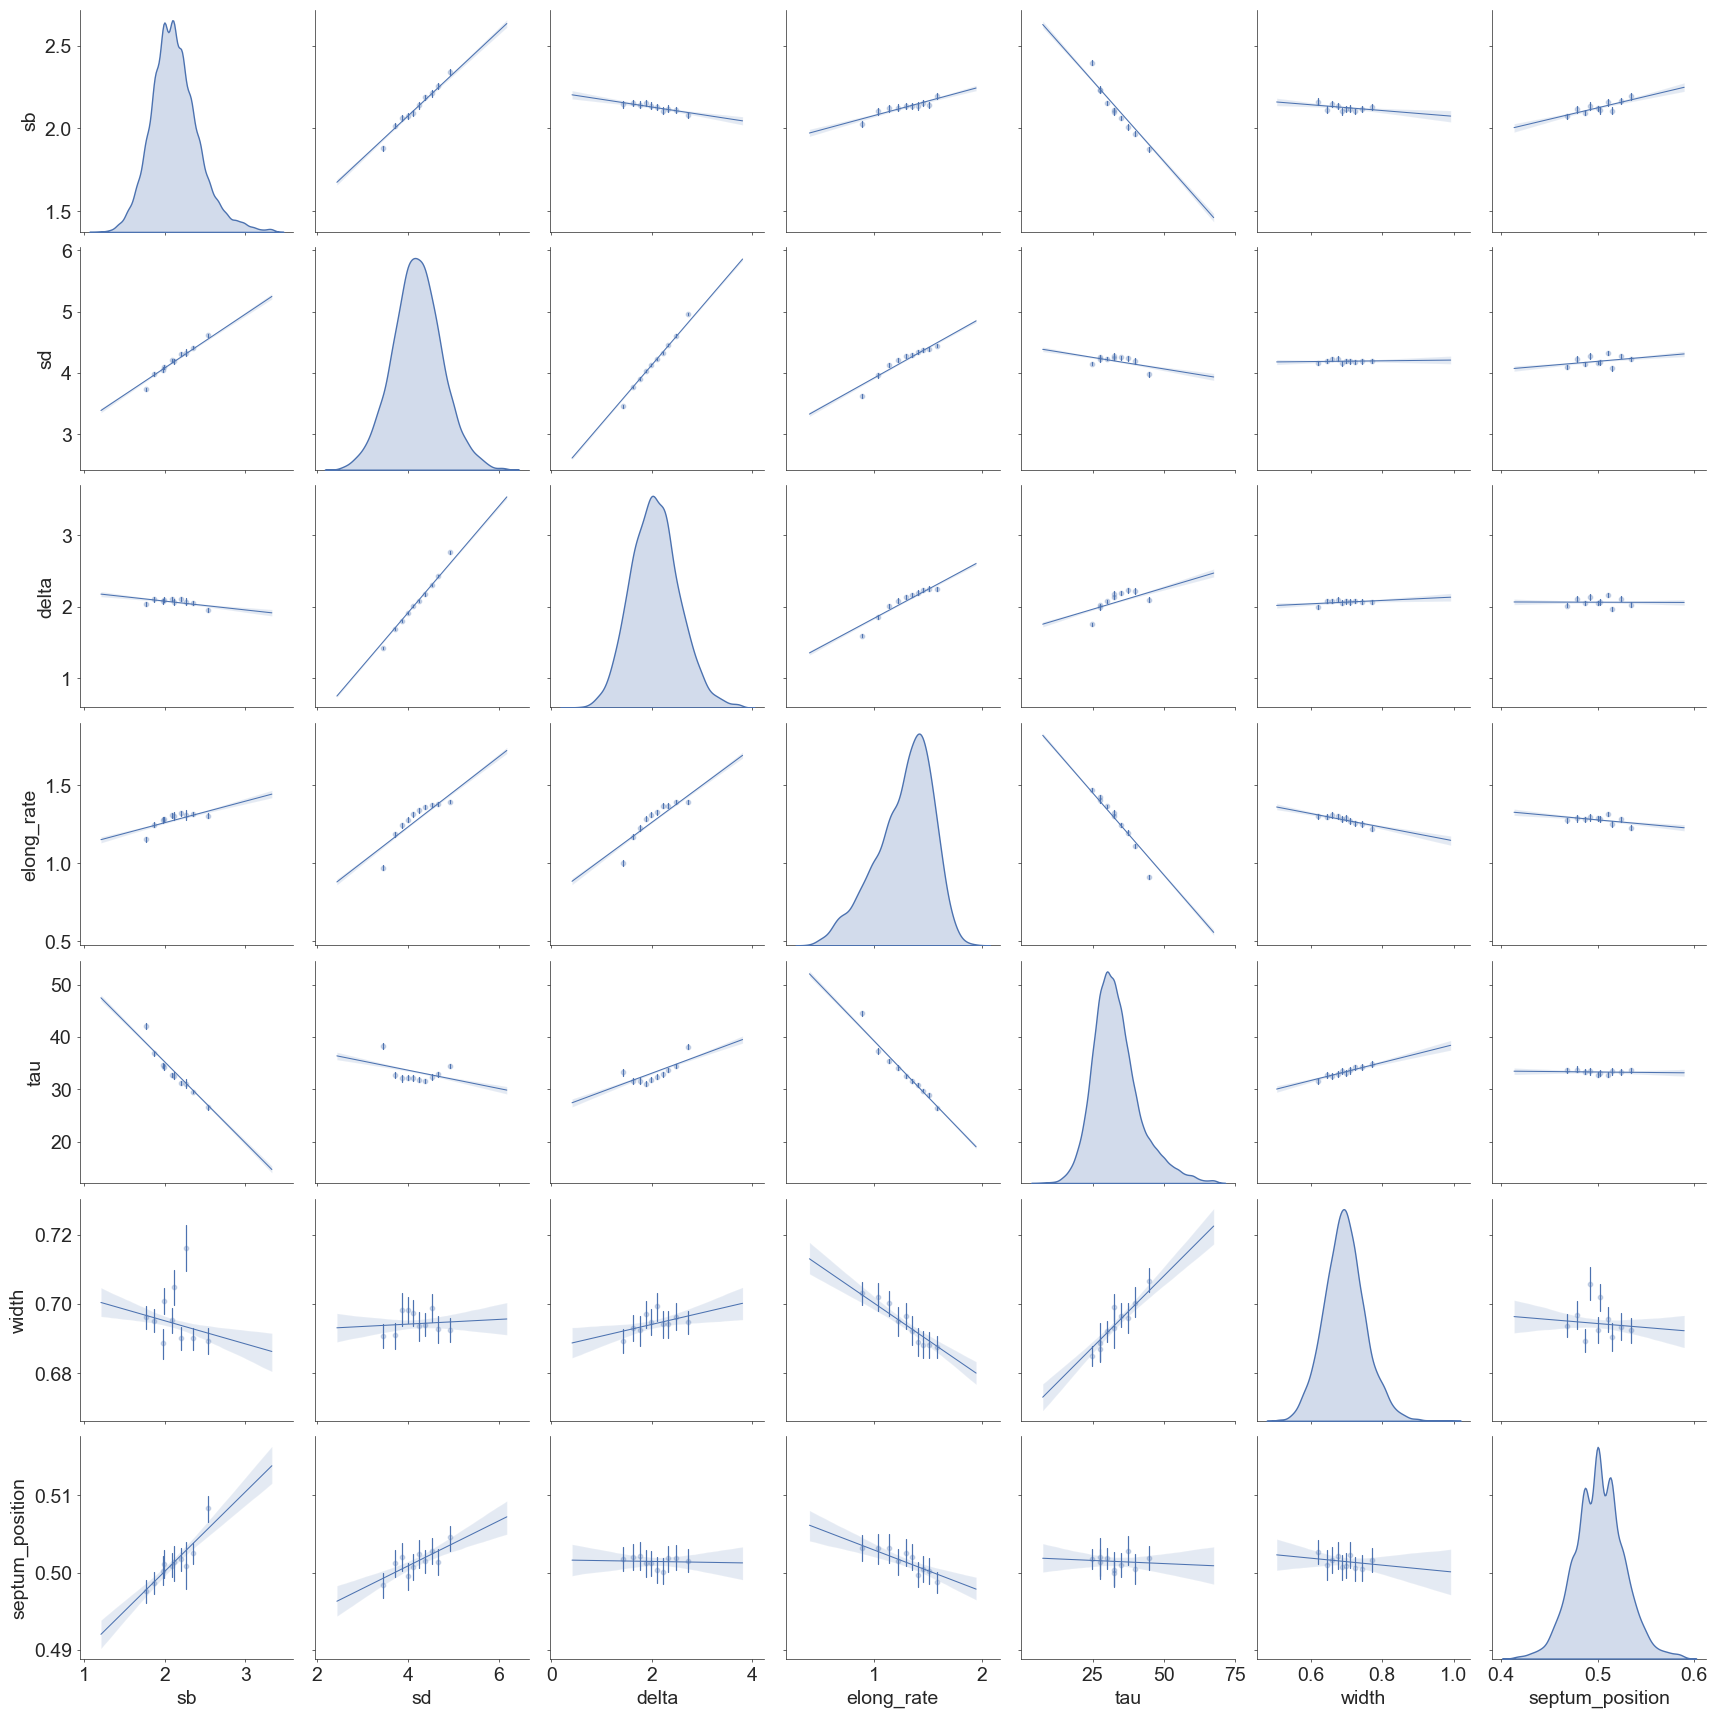

In [70]:
include_columns = ['sb', 'sd', 'delta', 'elong_rate', 'tau', 'width','septum_position']

g = sns.pairplot(fCells_df[include_columns], kind='reg',diag_kind = 'kde',
                 plot_kws={'scatter':True,'x_bins':10,'scatter_kws':{'alpha':0.25,'s':10}})

#### plot parameters over time

In [71]:
def plot_hex_time(Cells_df, t_int, time_mark='birth_time', x_extents=None, bin_extents=None):
    '''
    Plots cell parameters over time using a hex scatter plot and a moving average
    '''

    # lists for plotting and formatting
    columns = ['sb', 'elong_rate', 'sd', 'tau', 'delta', 'septum_position']
    titles = ['Length at Birth', 'Elongation Rate', 'Length at Division',
              'Generation Time', 'Delta', 'Septum Position']
    ylabels = ['$\mu$m', '$\lambda$', '$\mu$m', 'min', '$\mu$m','daughter/mother']

    # create figure, going to apply graphs to each axis sequentially
    fig, axes = plt.subplots(nrows=2, ncols=3,
                             figsize=[15,8], squeeze=False)

    ax = np.ravel(axes)
    # binning parameters, should be arguments
    binmin = 3 # minimum bin size to display
    bingrid = (20, 10) # how many bins to have in the x and y directions
    moving_window = 10 # window to calculate moving stat

    # bining parameters for each data type
    # bin_extent in within which bounds should bins go. (left, right, bottom, top)
    if x_extents == None:
        x_extents = (Cells_df['birth_time'].min(), Cells_df['birth_time'].max())

    if bin_extents == None:
        bin_extents = [(x_extents[0], x_extents[1], 0, 4),
                      (x_extents[0], x_extents[1], 0, 1.5),
                      (x_extents[0], x_extents[1], 0, 8),
                      (x_extents[0], x_extents[1], 0, 140),
                      (x_extents[0], x_extents[1], 0, 4),
                      (x_extents[0], x_extents[1], 0, 1),
                      (x_extents[0], x_extents[1], 0, 100),
                      (x_extents[0], x_extents[1], 0, 80),
                      (x_extents[0], x_extents[1], 0, 2)]

    # Now plot the filtered data
    for i, column in enumerate(columns):
        # get out just the data to be plot for one subplot
        time_df = Cells_df[[time_mark, column]].apply(pd.to_numeric)
        time_df.sort_values(by=time_mark, inplace=True)

        # plot the hex scatter plot
        p = ax[i].hexbin(time_df[time_mark], time_df[column],
                         mincnt=binmin, gridsize=bingrid, extent=bin_extents[i])

        xlims = x_extents
        bin_mean, bin_edges, bin_n = sps.binned_statistic(time_df[time_mark], time_df[column],
                    statistic='mean', bins=np.arange(xlims[0]-1, xlims[1]+1, moving_window))
        bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
        ax[i].plot(bin_centers, bin_mean, lw=4, alpha=0.8, color='yellow')

        ax[i].set_title(titles[i])
        ax[i].set_ylabel(ylabels[i])

        p.set_cmap(cmap=plt.cm.Blues) # set color and style
        
        if i>2:
            ax[i].set_xlabel('Time step')

    plt.tight_layout()

    return fig, ax

(0.0, 2.0)

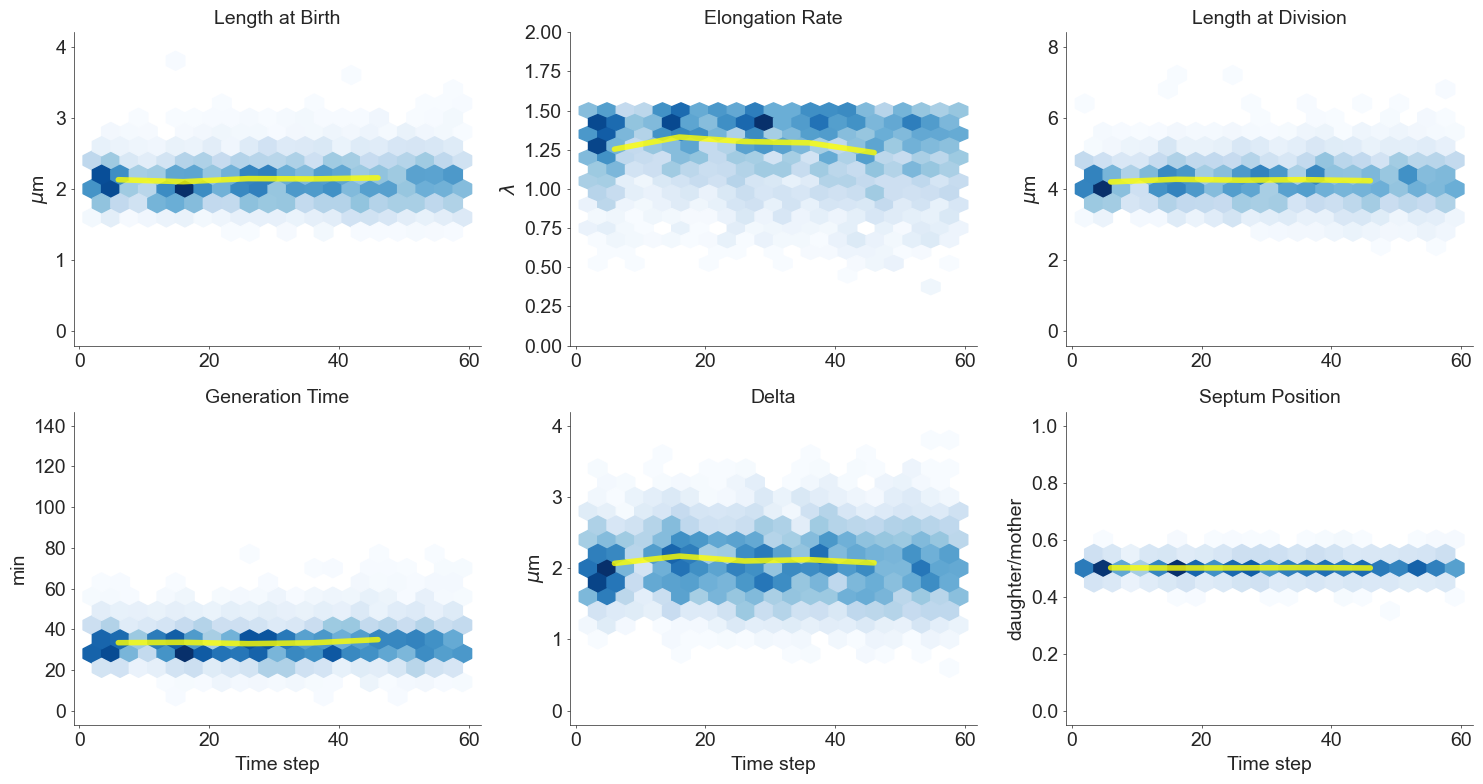

In [72]:
fig, ax = plot_hex_time(df.query('birth_time<60'),t_int=1)
sns.despine()
ax[1].set_ylim(0,2)